## Problem statement

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_{inf}}{T_{b} - T_{{inf}}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_{inf})}$


- $\epsilon_G=\epsilon(T_b-T_{inf})$


- $\epsilon_C=\beta(T_b-T_{inf})$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$


**Given a sample which contains 9 values of $x$ and $\theta$ predict $G$** 

In [24]:
eg = .6
ec = 0.4
N = 1.

## Import libraries 

In [25]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import scipy.io
from torchinfo import summary

## Hyper-parameters

In [26]:
seed_id = 30
steps = 30000
lr = 4e-3
nneurons = 20
nhiden_layers = 8
N_f = 50 #Total number of collocation points 
offset = .0001
G_init = 1.
print("Our guess o G is :", G_init)
device = 'cpu'

Our guess o G is : 1.0


### Set random seed and select device

In [27]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(seed_id)

# Random number generators in other libraries
np.random.seed(seed_id)

## Load data

In [28]:
relative_csv_path = "./../data/raw/heat_transfer_finn.csv"

# Load a random sample
fields_G = ['G']
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields = fields_T + fields_G
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = df_T.sample()
print('The data used is form the sample:',random_sample.index[0])
G_real = random_sample[fields_G].to_numpy()
T_real = random_sample[fields_T].to_numpy().T
X_real = np.linspace(0,1,T_real.shape[0]).reshape(-1,1)
X_real = X_real.astype(np.float32)
X_bc = X_real[-1].reshape(-1,1)

# compute theta 
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)])
Theta_real = Theta_real.astype(np.float32)
Theta_real = torch.from_numpy(Theta_real)
print('G_real is:',G_real)

# lower and uper bounds to normalize the input of net U
lb = min(X_real)
ub = max(X_real)

The data used is form the sample: 21
G_real is: [[0.8781378]]


### Collocation points ($loss_f$) and auxiliary loss vectors

In [29]:
# colocation points to evaluate PDE loss
f_hat = torch.zeros(N_f,1).to(device)
# axuliary theta to evaluate the boundary condition loss
theta_x_hat = torch.zeros(1,1).to(device)
# axuliary G to evaluate a costraint G value
lossG_hat = torch.zeros(1,1).to(device)
#
X_train_f = torch.linspace(lb[0] + offset,ub[0] - offset,N_f).reshape(-1,1)
print("The number of collocation points are", N_f)

The number of collocation points are 50


## Define architecture 

In [30]:
input_dim = X_real.shape[1]
output_dim = Theta_real.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])
print("The number of layers selected are", layers.size-1)

The number of layers selected are 9


## DNN class

In [31]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
            
        #convert to float
        a = x.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## Adapatative DNN class

In [32]:
class TrainableLambdas(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.lambda_params = nn.Parameter(torch.ones(1))
        # self.lambda_params = nn.Parameter(torch.ones(num_units)) # adaptative for each neuron
    def forward(self, x):
        return self.lambda_params * x

#  Deep Neural Network with adaptative activation functions
class AdaptativeDNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        
        'activation function'
        self.activation = nn.Tanh()
        
        self.lambdas = [TrainableLambdas(layers[i]) for i in range(1, len(layers) - 1)]
        
        for i,layer_coef in enumerate(self.lambdas):
            param_name = 'Lambda' + str(i)
            self.register_parameter(param_name, layer_coef.lambda_params)
        
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
            
        #convert to float
        a = x.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            a = self.linears[i](a)
                        
            a = self.activation(a)
            
            lambdas_layer = self.lambdas[i]
            
            a = lambdas_layer(a)
        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

### Test that alpha parameters are being added by clases constructors

In [33]:
# Print adaptative NN summary
adaptative_NN = AdaptativeDNN(layers)
print("The vnailla adaptatative NN summary is:") 
print(summary(adaptative_NN))

vanilla_NN = DNN(layers)
print("The vnailla NN summary is:")
print(summary(vanilla_NN))

The vnailla adaptatative NN summary is:
Layer (type:depth-idx)                   Param #
AdaptativeDNN                            8
├─Tanh: 1-1                              --
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       40
│    └─Linear: 2-2                       420
│    └─Linear: 2-3                       420
│    └─Linear: 2-4                       420
│    └─Linear: 2-5                       420
│    └─Linear: 2-6                       420
│    └─Linear: 2-7                       420
│    └─Linear: 2-8                       420
│    └─Linear: 2-9                       21
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
The vnailla NN summary is:
Layer (type:depth-idx)                   Param #
DNN                                      --
├─Tanh: 1-1                              --
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       40
│    └─Linear: 2-2                       420
│    └─Linea

## PINN class

In [34]:
class PINN():
    def __init__(self, layers, adaptative_lambdas = False):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='sum')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        self.G = torch.tensor([float(G_init)], requires_grad=True).float().to(device)  
                
        'Register parametes to be optimized'
        self.G = nn.Parameter(self.G)

        'Initialize our DNN'
        if adaptative_lambdas:
            self.dnn = AdaptativeDNN(layers).to(device)
        else:
            self.dnn = DNN(layers).to(device)

        'Register our new parameter'
        self.dnn.register_parameter('G', self.G)  

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "G": [],
                             "Total":[]}
        
        'Parameters trials'
        self.params_history = {"G": [] }

    def loss_data(self, x, theta_real, save = False):
                   
        if torch.is_tensor(theta_real) != True:         
            theta_real = torch.from_numpy(theta_real)
        
        theta_nn = self.dnn(x)
        loss_d = self.loss_function(theta_nn, theta_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, x_f, save = False):
                       
        # extract the PDE parameters
        G = self.G

        # clone the input data and add AD
        x = x_f.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        # copmute term to be derived
        aux = (1 + ec * theta) * theta_x

        aux_x = autograd.grad(aux, x, torch.ones(x_f.shape).to(device), create_graph=True)[0]
        
        # PDE f  = 0
        f = aux_x - N**2*theta + N**2*G*(1 + eg*theta)   

        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f, f_hat)
        
        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 

        return loss_f
    
    def loss_BC(self,x_bc, save = False):
        
        if torch.is_tensor(x_bc) != True:         
            x_bc = torch.from_numpy(x_bc)

        # clone the input data and add AD
        x = x_bc.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_bc.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        loss_bc = self.loss_function(theta_x, theta_x_hat)
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    
    def loss_G(self, save = False):
        lossG = 0.0
        G_NN = self.G
        if G_NN < 1e-5:
            K = 1000
            lossG = K * G_NN**2

        lossG = self.loss_function(torch.Tensor([lossG]), lossG_hat)
            

        save and self.loss_history["G"].append(lossG.to('cpu').detach().numpy())
                
        return lossG
        
    def loss(self, x_real, theta_real, x_f, x_bc, save = False):

        loss_d  = self.loss_data(x_real, theta_real, save)
        loss_f  = self.loss_PDE(x_f, save)
        loss_bc = self.loss_BC(x_bc, save)
        loss_g = self.loss_G(save)
        
        # weights should sum 1
        loss_val = loss_d + loss_f + loss_bc + loss_g

        if save:
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
            self.params_history["G"].append(self.G.to('cpu').data.numpy().copy())

        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_real, Theta_real, X_train_f, X_bc, True)
        
        loss.backward()
        
        self.iter += 1

        print(
            'LBFGS iter: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.5f]' %
            (   
                self.iter,
                loss.cpu().detach().numpy(),
                G_real,
                self.G.item(),
            )
        )

        
        return loss        
    
    'foward pass'
    def forward(self,x):
        return self.dnn(x)
    
    'test neural network with the norm '
    def test(self):
                
        theta_pred = self.dnn(X_real)
        # Relative L2 Norm of the error (Vector)
        error_vec = torch.linalg.norm((Theta_real - theta_pred),2)/torch.linalg.norm(Theta_real,2)  
        theta_pred = theta_pred.cpu().detach().numpy()
                        
        return error_vec, theta_pred

## Train the vanila model


In [35]:
'Neural Network Summary'
vanilla_pinn = PINN(layers, adaptative_lambdas=False)

'Neural Network Parameters'
params = list(vanilla_pinn.dnn.parameters())

'Mesure time'
start_time = time.time()

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(vanilla_pinn.closure)

elapsed_time_vanilla = time.time() - start_time

LBFGS iter: 1, Loss error(Train): 59.3482627869 , G_real = [0.87814], G_PINN = [1.00000]
LBFGS iter: 2, Loss error(Train): 59.2814369202 , G_real = [0.87814], G_PINN = [0.99998]
LBFGS iter: 3, Loss error(Train): 58.6814346313 , G_real = [0.87814], G_PINN = [0.99978]
LBFGS iter: 4, Loss error(Train): 55.7171630859 , G_real = [0.87814], G_PINN = [0.99877]
LBFGS iter: 5, Loss error(Train): 27.8028202057 , G_real = [0.87814], G_PINN = [0.98768]
LBFGS iter: 6, Loss error(Train): 27.4427604675 , G_real = [0.87814], G_PINN = [0.98749]
LBFGS iter: 7, Loss error(Train): 25.8404006958 , G_real = [0.87814], G_PINN = [0.98664]
LBFGS iter: 8, Loss error(Train): 10.9025506973 , G_real = [0.87814], G_PINN = [0.97729]
LBFGS iter: 9, Loss error(Train): 10.7853956223 , G_real = [0.87814], G_PINN = [0.97720]
LBFGS iter: 10, Loss error(Train): 10.2653264999 , G_real = [0.87814], G_PINN = [0.97683]
LBFGS iter: 11, Loss error(Train): 5.4765286446 , G_real = [0.87814], G_PINN = [0.97270]
LBFGS iter: 12, Loss

/home/mvanzulli/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LBFGS iter: 28, Loss error(Train): 1.2733662128 , G_real = [0.87814], G_PINN = [0.96602]
LBFGS iter: 29, Loss error(Train): 1.2608804703 , G_real = [0.87814], G_PINN = [0.96598]
LBFGS iter: 30, Loss error(Train): 1.1330264807 , G_real = [0.87814], G_PINN = [0.96559]
LBFGS iter: 31, Loss error(Train): 1.1283402443 , G_real = [0.87814], G_PINN = [0.96556]
LBFGS iter: 32, Loss error(Train): 1.1074290276 , G_real = [0.87814], G_PINN = [0.96543]
LBFGS iter: 33, Loss error(Train): 0.8989665508 , G_real = [0.87814], G_PINN = [0.96398]
LBFGS iter: 34, Loss error(Train): 0.8946863413 , G_real = [0.87814], G_PINN = [0.96393]
LBFGS iter: 35, Loss error(Train): 0.8756281734 , G_real = [0.87814], G_PINN = [0.96372]
LBFGS iter: 36, Loss error(Train): 0.6903062463 , G_real = [0.87814], G_PINN = [0.96143]
LBFGS iter: 37, Loss error(Train): 0.6875424981 , G_real = [0.87814], G_PINN = [0.96138]
LBFGS iter: 38, Loss error(Train): 0.6631527543 , G_real = [0.87814], G_PINN = [0.96093]
LBFGS iter: 39, Loss 

## Train apdatative model

In [36]:
'Neural Network Summary'
adaptative_pinn = PINN(layers, adaptative_lambdas=True)

'Neural Network Parameters'
params = list(adaptative_pinn.dnn.parameters())

'Mesure time'
start_time = time.time()

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(adaptative_pinn.closure)

elapsed_time_LBFGS = time.time() - start_time

LBFGS iter: 1, Loss error(Train): 130.4992980957 , G_real = [0.87814], G_PINN = [1.00000]
LBFGS iter: 2, Loss error(Train): 130.3908691406 , G_real = [0.87814], G_PINN = [0.99998]
LBFGS iter: 3, Loss error(Train): 129.4191894531 , G_real = [0.87814], G_PINN = [0.99983]
LBFGS iter: 4, Loss error(Train): 124.6674499512 , G_real = [0.87814], G_PINN = [0.99904]
LBFGS iter: 5, Loss error(Train): 101.6453704834 , G_real = [0.87814], G_PINN = [0.99472]
LBFGS iter: 6, Loss error(Train): 101.2119903564 , G_real = [0.87814], G_PINN = [0.99459]
LBFGS iter: 7, Loss error(Train): 99.2738800049 , G_real = [0.87814], G_PINN = [0.99396]
LBFGS iter: 8, Loss error(Train): 79.5417861938 , G_real = [0.87814], G_PINN = [0.98712]
LBFGS iter: 9, Loss error(Train): 78.9214477539 , G_real = [0.87814], G_PINN = [0.98685]
LBFGS iter: 10, Loss error(Train): 76.1508941650 , G_real = [0.87814], G_PINN = [0.98565]
LBFGS iter: 11, Loss error(Train): 48.7136154175 , G_real = [0.87814], G_PINN = [0.97243]
LBFGS iter: 1

# Losses vs iteration 

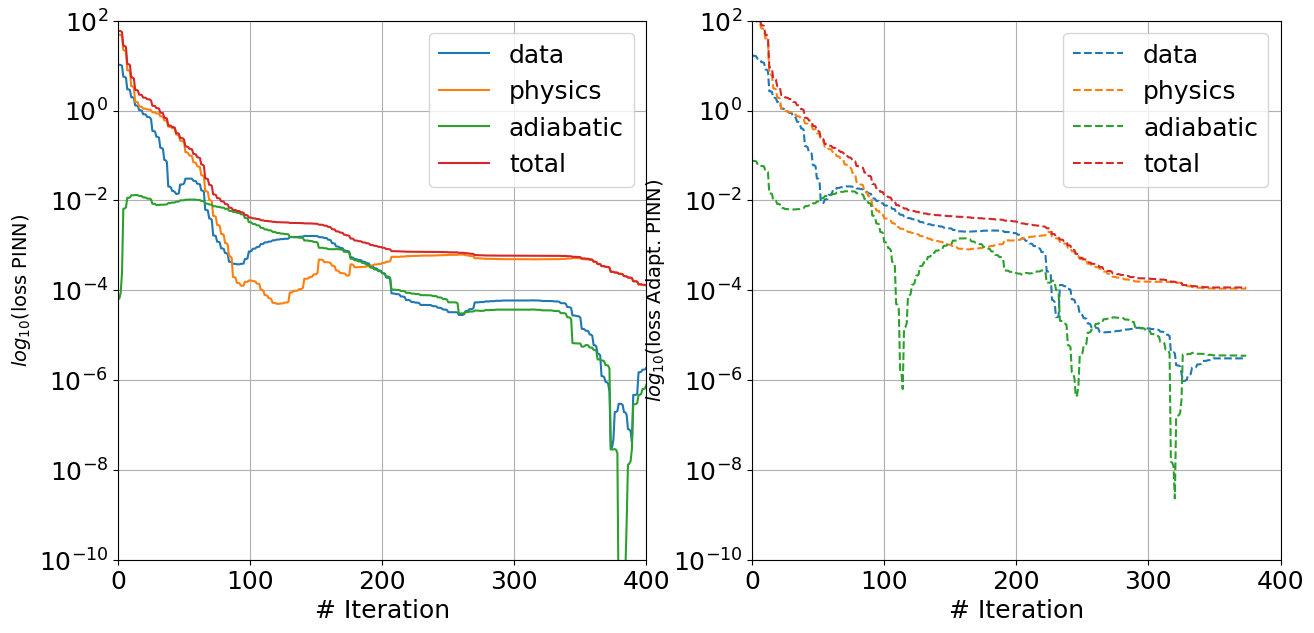

In [38]:
def plot_pinns_losses(vanilla_pinn, adaptative_pinn, path_fig, label_size = 10):

    ylim = (1e-10, 1e2)
    xlim = (0, 400)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Pin 1 loss evolution
    ax[0].cla()
    ax[0].plot(vanilla_pinn.loss_history["Data"] , label = 'data')
    ax[0].plot(vanilla_pinn.loss_history["PDE"] , label = 'physics')
    ax[0].plot(vanilla_pinn.loss_history["BC"] , label = 'adiabatic')
    ax[0].plot(vanilla_pinn.loss_history["Total"] , label = 'total')
    ax[0].set_xlabel('# Iteration', fontsize = 1.8*label_size)
    ax[0].set_ylabel(r'$log_{10}$(loss PINN)', fontsize = 1.4*label_size)
    ax[0].set_yscale('log')
    ax[0].legend(loc='upper right', fontsize = 1.8*label_size)
    ax[0].grid(True, which="both", ls="-")
    ax[0].tick_params(axis='both', which='major', labelsize=1.8*label_size)
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    
    # Pin 2 loss evolution
    ax[1].cla()
    ax[1].plot(adaptative_pinn.loss_history["Data"] , label = 'data', linestyle = '--')
    ax[1].plot(adaptative_pinn.loss_history["PDE"] , label = 'physics', linestyle = '--')
    ax[1].plot(adaptative_pinn.loss_history["BC"] , label = 'adiabatic', linestyle = '--')
    ax[1].plot(adaptative_pinn.loss_history["Total"] , label = 'total', linestyle = '--')
    ax[1].set_xlabel('# Iteration', fontsize = 1.8*label_size)
    ax[1].set_ylabel(r'$log_{10}$(loss Adapt. PINN)', fontsize = 1.4*label_size)
    ax[1].set_yscale('log')
    ax[1].legend(loc='upper right', fontsize = 1.8*label_size)
    ax[1].grid(True, which="both", ls="-")
    ax[1].tick_params(axis='both', which='major', labelsize=1.8*label_size)
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)


    fig.savefig(path_fig, bbox_inches='tight')


path_fig = './../../figures/PINN/loss_vs_epoch_adaptative.png'
plot_pinns_losses(vanilla_pinn, adaptative_pinn, path_fig)

# G vs iteration 

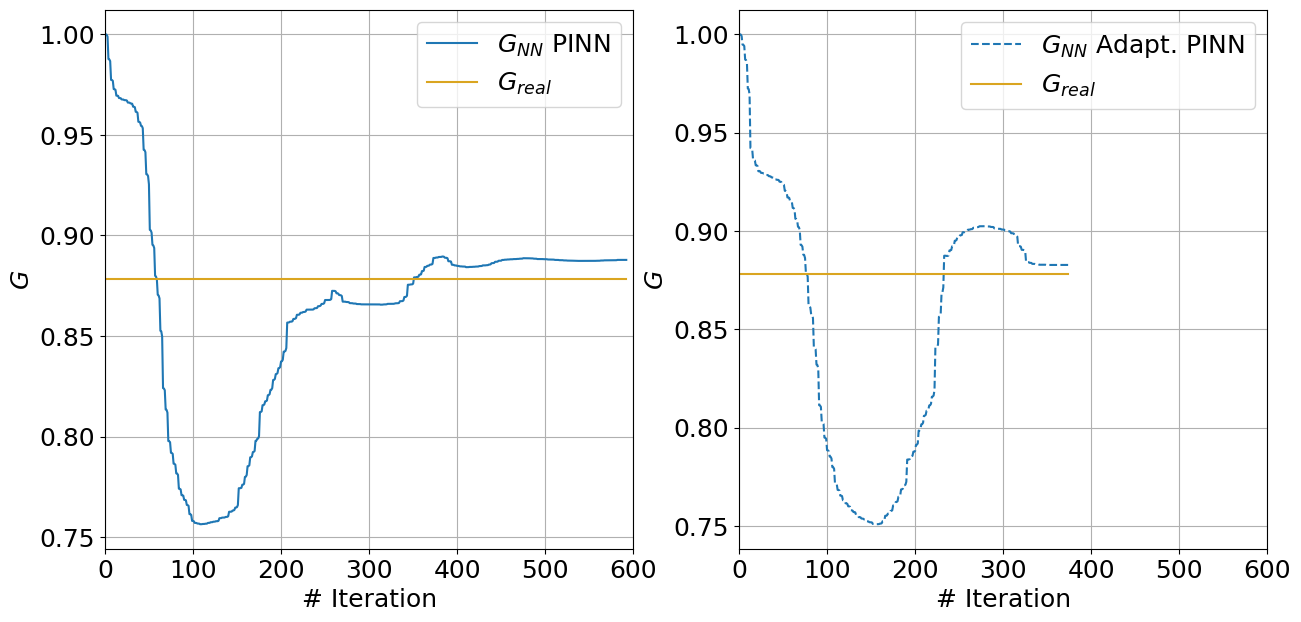

In [39]:
label_size = 10

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

xlim = (0, 600)

# G evolution with ADAM 
nsteps_adam = len(vanilla_pinn.params_history["G"])
ax[0].cla()
ax[0].plot(vanilla_pinn.params_history["G"], label = r'$G_{NN}$ PINN')
ax[0].set_xlabel('# Iteration', fontsize = 1.8*label_size)
ax[0].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[0].plot(range(nsteps_adam), G_real*np.ones((nsteps_adam,1)), label = r'$G_{real}$', color = 'goldenrod')
ax[0].grid(True, which="both", ls="-")
ax[0].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[0].legend(loc='upper right', fontsize = 1.8*label_size)
ax[0].set_xlim(xlim)

# G evolution with LBFGS 
nsteps_lbfgs = len(adaptative_pinn.params_history["G"])
ax[1].cla()
ax[1].plot(adaptative_pinn.params_history["G"], linestyle = '--', label = r'$G_{NN}$ Adapt. PINN')
ax[1].set_xlabel('# Iteration', fontsize = 1.8*label_size)
ax[1].set_ylabel(r'$G$', fontsize = 1.8*label_size)
ax[1].plot(range(nsteps_lbfgs), G_real*np.ones((nsteps_lbfgs,1)), label = r'$G_{real}$', color = 'goldenrod')
ax[1].grid(True, which="both", ls="-")
ax[1].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[1].legend(loc='upper right', fontsize = 1.8*label_size)
ax[1].set_xlim(xlim)


path_fig = './../../figures/PINN/G_evolution_adaptative.png'
fig.savefig(path_fig, bbox_inches='tight')
